# User data analysis exercise code

## Base Dataset

In [1]:
#basic
import numpy as np

#dataframe
import pandas as pd
import collections

#graph
import matplotlib.pyplot as plt

#statistics
from scipy import stats #paired t test
from sklearn.linear_model import LinearRegression #trend line
from sklearn.metrics import mean_squared_error, r2_score 

In [2]:
#data loading
df=pd.read_csv(r'C:\Users\Desktop\data.csv')

continuous=['day', 'age', 'country', 'gender', 'device_type',
       'is_active_user']
discrete=['swipes_sent', 'swipes_received', 'likes_sent',
       'likes_received', 'matches', 'messages_sent', 'messages_received']

In [3]:
#generate various variables
#generate count distinct variables
var_agg=['user_id', 'device_type', 'country']
df_unique=df[var_agg].groupby(['user_id'], as_index=False).agg(pd.Series.nunique)
df_unique.columns=['user_id', 'device_countd', 'country_countd']
df=pd.merge(df, df_unique, how='inner', on=['user_id'])

#first day
var_agg=['user_id', 'day', 'is_active_user', 'swipes_sent']
df_agg=df[var_agg].groupby(['user_id'], as_index=False).agg(['count', 'sum', 'min', 'max', ])

#column name list
name_var=df_agg.columns.get_level_values(0)
name_stat=df_agg.columns.get_level_values(1)
colname_new=[i+'_'+j for i,j in zip(name_var, name_stat)]

#holiday factor
df_agg.columns=colname_new
df_agg=df_agg.reset_index()
df_agg=df_agg[['user_id', 'day_count', 'day_min', 'is_active_user_sum', 'swipes_sent_max']]
df_agg.rename(columns={'is_active_user_sum': 'active_day_count'}, inplace=True)

#max swipes
df_agg['premium_user']=df_agg[['user_id', 'swipes_sent_max']].apply(lambda x: True if x.swipes_sent_max>=200 else False, axis=1)
df=pd.merge(df, df_agg[['user_id','day_count','active_day_count','premium_user']], how='inner', on=['user_id']).sort_values(['user_id'])

#new variable
#replace day2 to day
df['day2'] = pd.to_datetime(df['day'])
df['nth_day'] = df.groupby('user_id')['day2'].rank("dense", ascending=True).astype('int')
print(df.columns)

Index(['user_id', 'day', 'age', 'country', 'gender', 'device_type',
       'is_active_user', 'swipes_sent', 'swipes_received', 'likes_sent',
       'likes_received', 'matches', 'messages_sent', 'messages_received',
       'device_countd', 'country_countd', 'day_count', 'active_day_count',
       'premium_user', 'day2', 'nth_day'],
      dtype='object')


In [4]:
#proportion variables

#log in
df['log_rate']=df.apply(lambda x: x.active_day_count/x.day_count if x.day_count!=0 else np.nan, axis=1)
df['like_sent_rate']=df.apply(lambda x: x.likes_sent/x.swipes_sent if x.swipes_sent!=0 else np.nan, axis=1)
df['match_sent_rate']=df.apply(lambda x: x.matches/x.likes_sent if x.likes_sent!=0 else np.nan, axis=1)
df['message_sent_rate']=df.apply(lambda x: x.messages_sent/x.matches if x.matches!=0 else np.nan, axis=1)

#attractive ness of the user
df['like_received_rate']=df.apply(lambda x: x.likes_received/x.swipes_received if x.swipes_received!=0 else np.nan, axis=1)
df['match_received_rate']=df.apply(lambda x: x.matches/x.likes_received if x.likes_received!=0 else np.nan, axis=1)
df['message_received_rate']=df.apply(lambda x: x.messages_received/x.matches if x.matches!=0 else np.nan, axis=1)
df['message_ratio']=df.apply(lambda x: x.messages_received/x.messages_sent if x.messages_sent!=0 else np.nan, axis=1)

In [5]:
holiday_dict={'Spain':{pd.to_datetime("2020-01-01"), pd.to_datetime("2020-01-06")}, ##
'Thailand':{pd.to_datetime("2020-01-01")}, ##
'Argentina':{pd.to_datetime("2020-01-01")}, ##
'Indonesia':{pd.to_datetime("2020-01-01"),pd.to_datetime("2020-01-25")}, ##
'Italy':{pd.to_datetime("2020-01-01"), pd.to_datetime("2020-01-06")}}    

long_dict={'Spain':{pd.to_datetime("2020-01-02"), pd.to_datetime("2020-01-03")}, ##
'Thailand':{pd.to_datetime("2020-01-01")}, ##
'Argentina':{pd.to_datetime("2020-01-01")}, ##
'Indonesia':{pd.to_datetime("2020-01-01"),pd.to_datetime("2020-01-23"), pd.to_datetime("2020-01-27")}, ##
'Italy':{pd.to_datetime("2020-01-02"), pd.to_datetime("2020-01-03")}} 


print(holiday_dict)

weekend_set={pd.to_datetime("2020-01-03"), pd.to_datetime("2020-01-04"), pd.to_datetime("2020-01-05"), 
             pd.to_datetime("2020-01-10"), pd.to_datetime("2020-01-11"), pd.to_datetime("2020-01-12"),
             pd.to_datetime("2020-01-17"), pd.to_datetime("2020-01-18"), pd.to_datetime("2020-01-19"), 
             pd.to_datetime("2020-01-24"), pd.to_datetime("2020-01-25"), pd.to_datetime("2020-01-26")
            }

print(weekend_set)

df['holiday']=df.apply(lambda x: 1 if x.day2 in holiday_dict[x.country] else 0, axis=1)
df['weekend']=df.apply(lambda x: 1 if x.day2 in weekend_set else 0, axis=1)
df['long_weekend']=df.apply(lambda x: 1 if x.day2 in long_dict[x.country] else 0, axis=1)

{'Spain': {Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-01 00:00:00')}, 'Thailand': {Timestamp('2020-01-01 00:00:00')}, 'Argentina': {Timestamp('2020-01-01 00:00:00')}, 'Indonesia': {Timestamp('2020-01-25 00:00:00'), Timestamp('2020-01-01 00:00:00')}, 'Italy': {Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-01 00:00:00')}}
{Timestamp('2020-01-11 00:00:00'), Timestamp('2020-01-03 00:00:00'), Timestamp('2020-01-18 00:00:00'), Timestamp('2020-01-25 00:00:00'), Timestamp('2020-01-04 00:00:00'), Timestamp('2020-01-26 00:00:00'), Timestamp('2020-01-24 00:00:00'), Timestamp('2020-01-17 00:00:00'), Timestamp('2020-01-12 00:00:00'), Timestamp('2020-01-05 00:00:00'), Timestamp('2020-01-19 00:00:00'), Timestamp('2020-01-10 00:00:00')}


In [6]:
#active day count
df_active_log=df[df['is_active_user']==1]#[['user_id', 'is_active_user', 'nth_day', 'day2']]
df_active_log['nth_active_day'] = df_active_log.groupby('user_id')['day2'].rank("dense", ascending=True).astype('int')
df_active_log.sort_values(['user_id','nth_active_day'], inplace=True)

C:\Users\cho75689\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cho75689\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
#join back with df
df_active_log=df_active_log[['user_id', 'day2', 'nth_active_day']]

#order with user id and nth_day
df_total=pd.merge(df, df_active_log, how='left', on=['user_id','day2']).sort_values(['user_id','nth_day'])
print(df_total.columns)
df_total

Index(['user_id', 'day', 'age', 'country', 'gender', 'device_type',
       'is_active_user', 'swipes_sent', 'swipes_received', 'likes_sent',
       'likes_received', 'matches', 'messages_sent', 'messages_received',
       'device_countd', 'country_countd', 'day_count', 'active_day_count',
       'premium_user', 'day2', 'nth_day', 'log_rate', 'like_sent_rate',
       'match_sent_rate', 'message_sent_rate', 'like_received_rate',
       'match_received_rate', 'message_received_rate', 'message_ratio',
       'holiday', 'weekend', 'long_weekend', 'nth_active_day'],
      dtype='object')


,user_id,day,age,country,gender,device_type,is_active_user,swipes_sent,swipes_received,likes_sent,...,match_sent_rate,message_sent_rate,like_received_rate,match_received_rate,message_received_rate,message_ratio,holiday,weekend,long_weekend,nth_active_day
0,1,2020-01-01 00:00:00,23,Argentina,Female,android,0,0,31,0,...,NaN,NaN,0.645161,0.000000,NaN,NaN,1,0,1,NaN
17,1,2020-01-02 00:00:00,23,Argentina,Female,android,0,0,9,0,...,NaN,NaN,0.666667,0.000000,NaN,NaN,0,0,0,NaN
24,1,2020-01-03 00:00:00,23,Argentina,Female,android,0,0,4,0,...,NaN,NaN,0.750000,0.000000,NaN,NaN,0,1,0,NaN
19,1,2020-01-04 00:00:00,23,Argentina,Female,android,0,0,2,0,...,NaN,NaN,0.500000,0.000000,NaN,NaN,0,1,0,NaN
20,1,2020-01-05 00:00:00,23,Argentina,Female,android,1,200,153,8,...,0.375000,1.333333,0.640523,0.030612,1.666667,1.25,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35758,2197,2020-01-28 00:00:00,19,Indonesia,Male,ios,0,0,23,0,...,NaN,NaN,0.173913,0.000000,NaN,NaN,0,0,0,NaN
35759,2197,2020-01-29 00:00:00,19,Indonesia,Male,ios,1,0,43,0,...,NaN,NaN,0.116279,0.000000,NaN,NaN,0,0,0,28.0
35760,2197,2020-01-30 00:00:00,19,Indonesia,Male,ios,1,105,39,46,...,0.065217,0.000000,0.051282,1.500000,0.333333,NaN,0,0,0,29.0
35777,2197,2020-01-31 00:00:00,19,Indonesia,Male,ios,1,0,35,0,...,NaN,NaN,0.057143,0.000000,NaN,1.00,0,0,0,30.0


<h3>EDA<h3>

C:\Users\cho75689\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  # This is added back by InteractiveShellApp.init_path()


(35780, 32)
Index(['user_id', 'day', 'age', 'country', 'gender', 'device_type',
       'is_active_user', 'swipes_sent', 'swipes_received', 'likes_sent',
       'likes_received', 'matches', 'messages_sent', 'messages_received',
       'device_countd', 'country_countd', 'day_count', 'active_day_count',
       'premium_user', 'day2', 'nth_day', 'log_rate', 'like_sent_rate',
       'match_sent_rate', 'message_sent_rate', 'like_received_rate',
       'match_received_rate', 'message_received_rate', 'message_ratio',
       'holiday', 'weekend', 'long_weekend'],
      dtype='object')
day
Counter({'2020-01-28 00:00:00': 1272, '2020-01-30 00:00:00': 1265, '2020-01-29 00:00:00': 1247, '2020-01-26 00:00:00': 1245, '2020-01-27 00:00:00': 1241, '2020-01-31 00:00:00': 1223, '2020-01-25 00:00:00': 1221, '2020-01-24 00:00:00': 1199, '2020-01-23 00:00:00': 1172, '2020-01-22 00:00:00': 1166, '2020-01-21 00:00:00': 1154, '2020-01-06 00:00:00': 1142, '2020-01-20 00:00:00': 1141, '2020-01-07 00:00:00': 1136

C:\Users\cho75689\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\cho75689\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\cho75689\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:

array([[<AxesSubplot:title={'center':'likes_received'}>,
        <AxesSubplot:title={'center':'likes_sent'}>,
        <AxesSubplot:title={'center':'matches'}>],
       [<AxesSubplot:title={'center':'messages_received'}>,
        <AxesSubplot:title={'center':'messages_sent'}>,
        <AxesSubplot:title={'center':'swipes_received'}>],
       [<AxesSubplot:title={'center':'swipes_sent'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

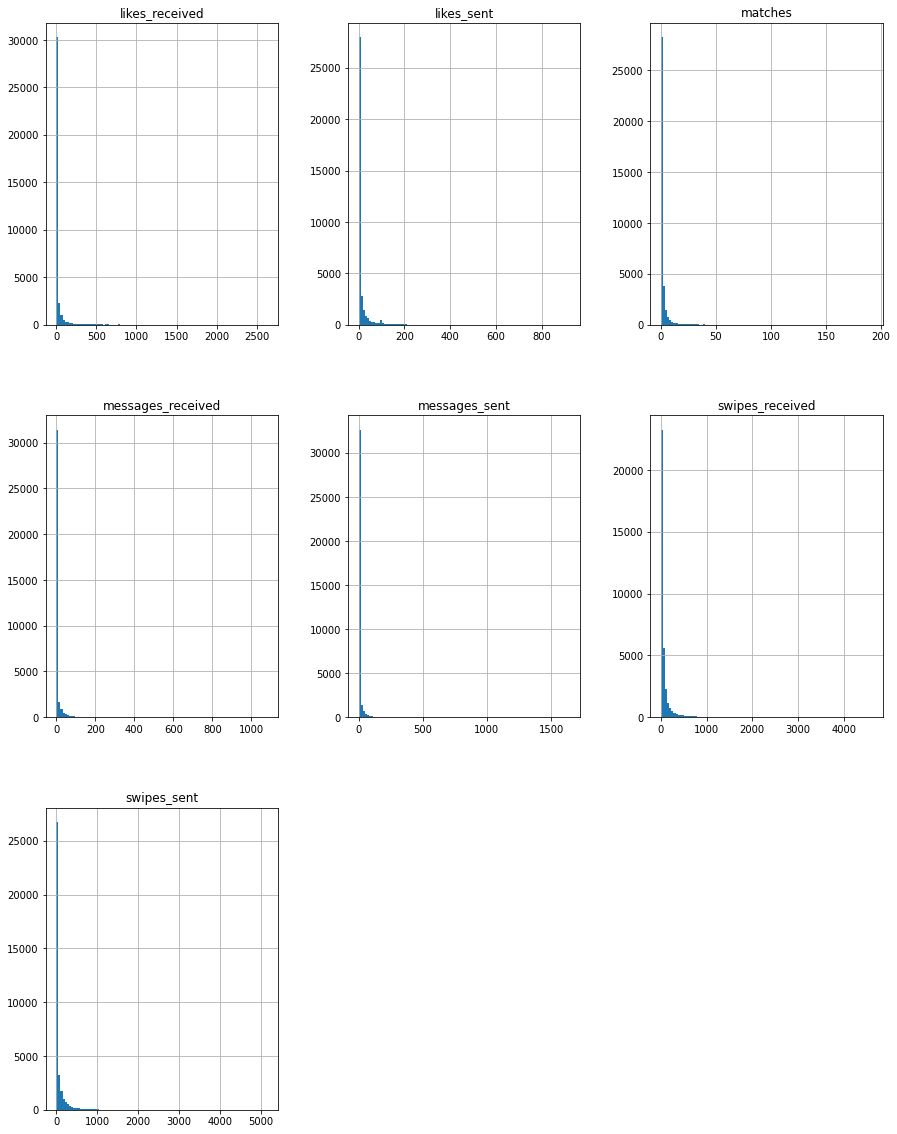

In [8]:
#EDA for discrete distributions
print(df.shape)
print(df.columns)
for i in list(continuous):
    print(i)
    print(collections.Counter(df[i]))

#EDA graphs of each continuous distriution 
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df[discrete].hist(ax=ax, bins=100)

C:\Users\cho75689\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys
C:\Users\cho75689\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\cho75689\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\cho75689\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecati

array([[<AxesSubplot:title={'center':'like_received_rate'}>,
        <AxesSubplot:title={'center':'like_sent_rate'}>,
        <AxesSubplot:title={'center':'log_rate'}>],
       [<AxesSubplot:title={'center':'match_received_rate'}>,
        <AxesSubplot:title={'center':'match_sent_rate'}>,
        <AxesSubplot:title={'center':'message_ratio'}>],
       [<AxesSubplot:title={'center':'message_received_rate'}>,
        <AxesSubplot:title={'center':'message_sent_rate'}>,
        <AxesSubplot:>]], dtype=object)

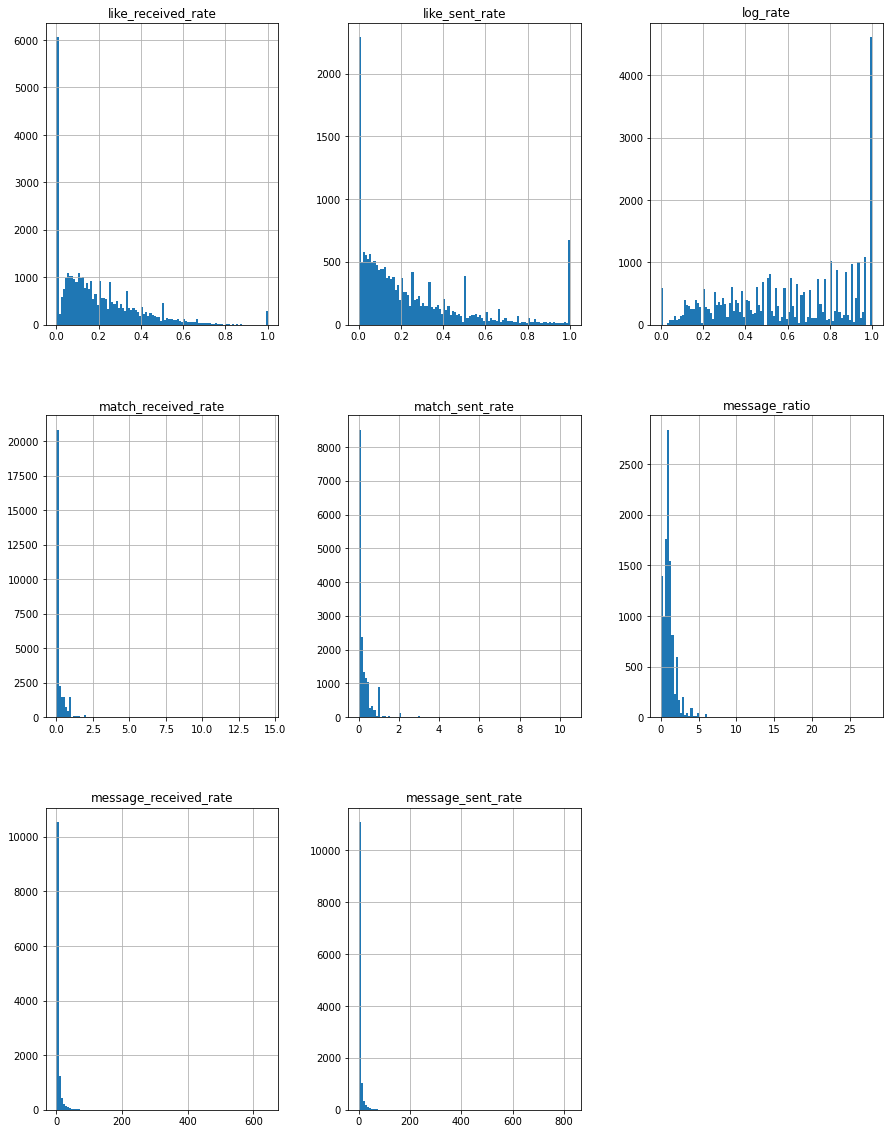

In [9]:
#EDA: proportionate variable plot
prop_var=['log_rate', 'like_sent_rate', 'match_sent_rate', 'message_sent_rate', 
          'like_received_rate', 'match_received_rate', 'message_received_rate', 'message_ratio']

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df[prop_var].hist(ax=ax, bins=100)

## Paired T-Test on Hypothesis
$H_0$: Trips don’t affect user behavior (Swipe/Like/Message)<br>
$H_1$:Trips do affect user behavior (Swipe/Like/Message)

In [10]:
#paired t-test
df_total['Day']=df_total.apply(lambda x: x.day2.day, axis=1)

sample=[1418, 1481, 1352, 1187, 1172, 909, 785, 2171, 2080, 1932, 1832, 1186, 967, 909]
sample_travel=df_total[df_total['user_id'].isin(sample)]
sample_travel=sample_travel[sample_travel['is_active_user']==1]

var_agg=['Day', 'country', 'user_id', 'swipes_sent', 'likes_sent', 'messages_sent']
df_agg=sample_travel[var_agg].groupby(['user_id','country']).agg(['count', 'sum', 'mean'])
df_agg=df_agg.unstack(level='country')

#column name list
name_var=df_agg.columns.get_level_values(0)
name_stat=df_agg.columns.get_level_values(1)
name_coutry=df_agg.columns.get_level_values(2)
colname_new=[i+'_'+j+'_'+z for i,j,z in zip(name_var, name_stat,name_coutry)]

#holiday factor
df_agg.columns=colname_new
df_agg

,Day_count_Indonesia,Day_count_Italy,Day_count_Spain,Day_count_Thailand,Day_sum_Indonesia,Day_sum_Italy,Day_sum_Spain,Day_sum_Thailand,Day_mean_Indonesia,Day_mean_Italy,...,messages_sent_count_Spain,messages_sent_count_Thailand,messages_sent_sum_Indonesia,messages_sent_sum_Italy,messages_sent_sum_Spain,messages_sent_sum_Thailand,messages_sent_mean_Indonesia,messages_sent_mean_Italy,messages_sent_mean_Spain,messages_sent_mean_Thailand
user_id,,,,,,,,,,,,,,,,,,,,,
785,NaN,7.0,2.0,NaN,NaN,196.0,47.0,NaN,NaN,28.000000,...,2.0,NaN,NaN,66.0,18.0,NaN,NaN,9.428571,9.000000,NaN
909,16.0,NaN,NaN,7.0,347.0,NaN,NaN,70.0,21.6875,NaN,...,NaN,7.0,62.0,NaN,NaN,65.0,3.875000,NaN,NaN,9.285714
967,NaN,17.0,2.0,NaN,NaN,258.0,21.0,NaN,NaN,15.176471,...,2.0,NaN,NaN,2.0,0.0,NaN,NaN,0.117647,0.000000,NaN
1172,NaN,4.0,2.0,NaN,NaN,10.0,21.0,NaN,NaN,2.500000,...,2.0,NaN,NaN,85.0,15.0,NaN,NaN,21.250000,7.500000,NaN
1186,NaN,4.0,27.0,NaN,NaN,46.0,450.0,NaN,NaN,11.500000,...,27.0,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN
1187,6.0,NaN,NaN,1.0,165.0,NaN,NaN,31.0,27.5000,NaN,...,NaN,1.0,65.0,NaN,NaN,0.0,10.833333,NaN,NaN,0.000000
1352,NaN,1.0,1.0,NaN,NaN,18.0,2.0,NaN,NaN,18.000000,...,1.0,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN
1418,NaN,1.0,4.0,NaN,NaN,19.0,26.0,NaN,NaN,19.000000,...,4.0,NaN,NaN,1.0,0.0,NaN,NaN,1.000000,0.000000,NaN
1481,NaN,NaN,7.0,6.0,NaN,NaN,93.0,171.0,NaN,NaN,...,7.0,6.0,NaN,NaN,6.0,23.0,NaN,NaN,0.857143,3.833333


In [3]:
home_swipe_usage=[81, 59.411765, 52.518519, 84.000000, 51.153846, 379.444444, 69.000000, 81.0, 290.0, 209.285714, 145.000000, 340.750000, 0.000000, 15.000000]
travel_swipe_usage=[518.857143, 3.000000, 32.250000, 34.125000, 31.500000, 348.666667, 16.400000, 518.857143, 27.000000, 595.500000, 152.857143, 69.000000, 6.000000, 498.000000]
stats.ttest_rel(home_swipe_usage,travel_swipe_usage)

Ttest_relResult(statistic=-1.0402850148704428, pvalue=0.31716925301809323)

In [4]:
home_like_usage=[5.75, 16.647059, 2.777778, 12.409091, 7.423077, 57.222222, 16.600000, 5.75, 34.00, 2.142857, 100.500000, 70.250000, 0.000000, 0.500000]
travel_like_usage=[14.285714, 1.500000, 0.250000, 4.625000, 3.500000, 50.333333, 2.800000, 14.285714, 1.000000, 9.166667, 116.428571, 16.500000, 4.000000, 74.000000]
stats.ttest_rel(home_like_usage,travel_like_usage)

Ttest_relResult(statistic=0.18261984266428455, pvalue=0.8579134572584255)

In [13]:
home_message_usage=[3.875, 0.117647, 0.000000, 6.136364, 1.500000, 15.666667, 2.000000, 3.875000, 10.833333, 0.857143, 9.000000, 21.250000, 0.000000, 0.000000]
travel_message_usage=[9.28714, 0.000000, 0.000000, 3.750000, 0.000000, 11.666667, 1.400000, 9.285714, 0.000000, 3.833333, 9.428571, 7.500000, 0.000000, 1.000000]
stats.ttest_rel(home_message_usage, travel_message_usage)

Ttest_relResult(statistic=0.8921417245954743, pvalue=0.3885323739077998)

## Images in the Report
<ul>
<li>Scatter Plot</li>
</ul>

In [14]:
df_user=df_total[['user_id', 'is_active_user']].groupby(['user_id']).is_active_user.mean().reset_index()
df_user.rename(columns={'is_active_user':'log rate'}, inplace=True)
ex=df_total[df_total['nth_active_day']==1][['user_id', 'day2']].rename(columns={'day2': 'First_Active_Date'})
df_user=pd.merge(df_user, ex, how='left', on='user_id')

ex=df_total[df_total['nth_day']==1][['user_id', 'day2']].rename(columns={'day2': 'First_Date'})
df_user=pd.merge(df_user, ex, how='left', on='user_id')
df_user['First_User_Flag']=df_user['First_Active_Date']==df_user['First_Date']
#df_user['First_User_Flag']=
df_user['First_User_Flag']=df_user.apply(lambda x: 'no_login' if pd.isnull(x.First_Active_Date) else str(x.First_User_Flag), axis=1)
df_user=pd.merge(df_user, df_total[['user_id', 'day2', 'likes_sent', 'matches','messages_received']], left_on=['user_id', 'First_Active_Date'], right_on=['user_id', 'day2'], how='left')
df_user['Match/likes_sent ratio on First Day']=df_user.apply(lambda x: x.matches/x.likes_sent if x.likes_sent!=0 else np.nan , axis=1)
df_user['Message_received/Matches ratio on First Day']=df_user.apply(lambda x: x.messages_received/x.matches if x.matches!=0 else np.nan , axis=1)

df_user=df_user[~df_user['user_id'].isin([434, 1319, 2068])]

<function matplotlib.pyplot.close(fig=None)>

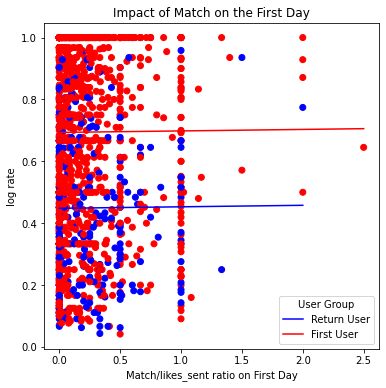

In [15]:
def color(x):
    col_l=[]
    
    for i in range(len(x)):
        
        if x[i]==0:
            col_l.extend("b")
        else:
            col_l.extend("r")
            
    return(col_l)

def sep(x,cat,y,k):
    
    x_k=[]
    y_k=[]
    
    for i in range(len(x)):
        
        if cat[i]==k:
            x_k.append(x[i])
            y_k.append(y[i])
            
    return(x_k,y_k)

import operator

df_plot=df_user.dropna(subset=['Match/likes_sent ratio on First Day', 'log rate'])
df_plot=df_plot[df_plot['First_User_Flag']!='no_login']
df_plot['First_User_Flag']=df_plot.apply(lambda x: 1 if x.First_User_Flag=='True' else 0 , axis=1)

x_poly=df_plot[['Match/likes_sent ratio on First Day', 'First_User_Flag']].values.reshape(-1,2)
y=df_plot['log rate'].values.reshape(-1,1)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)

#print('Slope:' ,model.coef_)
#print('Intercept:', model.intercept_)
#print('Root mean squared error: ', rmse)
#print('R2 score: ', r2)

c=color(x_poly[:,1])
x0,y_poly_pred0 =sep(x_poly[:,0],x_poly[:,1],y_poly_pred,0)
x1,y_poly_pred1 =sep(x_poly[:,0],x_poly[:,1],y_poly_pred,1)

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x0,y_poly_pred0), key=sort_axis)
x_plot0, y_poly_pred_plot0 = zip(*sorted_zip)
sorted_zip = sorted(zip(x1,y_poly_pred1), key=sort_axis)
x_plot1, y_poly_pred_plot1 = zip(*sorted_zip)

plt.figure(figsize=(6, 6))
plt.scatter(x_poly[:,0], y, color=c)
plt.plot(x_plot0, y_poly_pred_plot0, color='blue', label='Return User')
plt.plot(x_plot1, y_poly_pred_plot1, color='red', label='First User')
plt.legend(title='User Group', loc='lower right')
plt.xlabel('Match/likes_sent ratio on First Day')
plt.ylabel('log rate')
plt.title('Impact of Match on the First Day')


plt.savefig('Impact of Match on the First Day.png', format='png')
plt.close

<function matplotlib.pyplot.close(fig=None)>

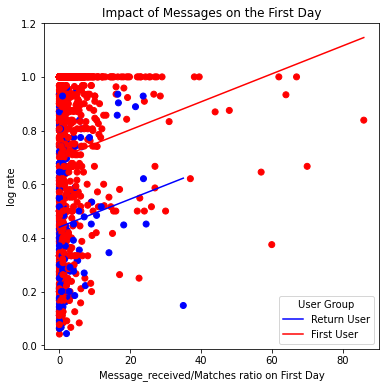

In [16]:

df_plot=df_user.dropna(subset=['Message_received/Matches ratio on First Day', 'log rate'])
df_plot=df_plot[df_plot['First_User_Flag']!='no_login']
df_plot['First_User_Flag']=df_plot.apply(lambda x: 1 if x.First_User_Flag=='True' else 0 , axis=1)

x_poly=df_plot[['Message_received/Matches ratio on First Day', 'First_User_Flag']].values.reshape(-1,2)
y=df_plot['log rate'].values.reshape(-1,1)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

#print('Slope:' ,model.coef_)
#print('Intercept:', model.intercept_)
#print('Root mean squared error: ', rmse)
#print('R2 score: ', r2)

c=color(x_poly[:,1])
x0,y_poly_pred0 =sep(x_poly[:,0],x_poly[:,1],y_poly_pred,0)
x1,y_poly_pred1 =sep(x_poly[:,0],x_poly[:,1],y_poly_pred,1)

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x0,y_poly_pred0), key=sort_axis)
x_plot0, y_poly_pred_plot0 = zip(*sorted_zip)
sorted_zip = sorted(zip(x1,y_poly_pred1), key=sort_axis)
x_plot1, y_poly_pred_plot1 = zip(*sorted_zip)

plt.figure(figsize=(6, 6))
plt.scatter(x_poly[:,0], y, color=c)
plt.plot(x_plot0, y_poly_pred_plot0, color='blue', label='Return User')
plt.plot(x_plot1, y_poly_pred_plot1, color='red', label='First User')
plt.legend(title='User Group', loc='lower right')
plt.xlabel('Message_received/Matches ratio on First Day')
plt.ylabel('log rate')
plt.title('Impact of Messages on the First Day')

plt.savefig('Impact of Messages on the First Day.png', format='png')
plt.close

<h3>Images in the Report<h3>
<ul>
<li>Line Charts</li>
</ul>

<function matplotlib.pyplot.close(fig=None)>

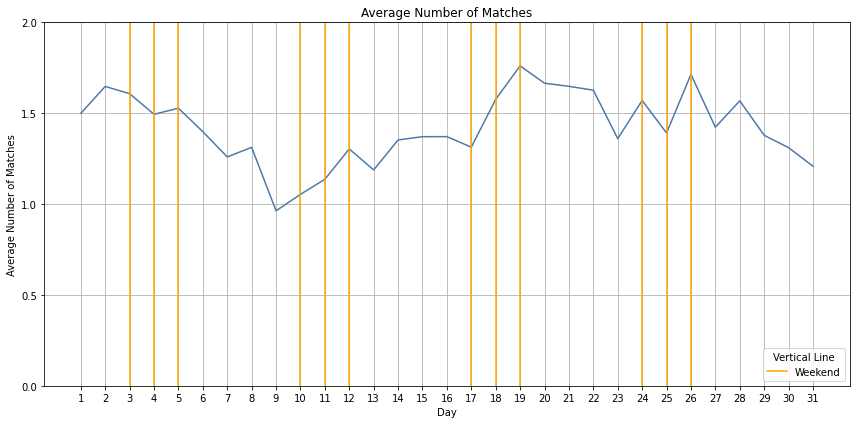

In [17]:
import matplotlib.pyplot as plt
import numpy as np
df_total['Day']=df_total.apply(lambda x: x.day2.day, axis=1)

var_agg=['Day', 'matches']
df_agg=df_total[var_agg].groupby(['Day']).mean()
df_agg

plt.figure(figsize=(12, 6))
plt.plot(df_agg['matches'], color='#4E79A7')

plt.xlabel('Day')
plt.ylabel('Average Number of Matches')

plt.xticks(np.arange(1, 32, 1)) 
plt.yticks(np.arange(0, 2.5, 0.5))
plt.grid()

xpoints = [3,4,5,10,11,12,17,18,19,24,25,26]
plt.axvline(3, color='orange', label='Weekend')
for p in xpoints[1:]:
    plt.axvline(p, color='orange')
    
plt.title('Average Number of Matches')
plt.legend(title='Vertical Line', loc='lower right')
plt.tight_layout()

plt.savefig('Average_Number_of_Matches.png', format='png')
plt.close

<function matplotlib.pyplot.close(fig=None)>

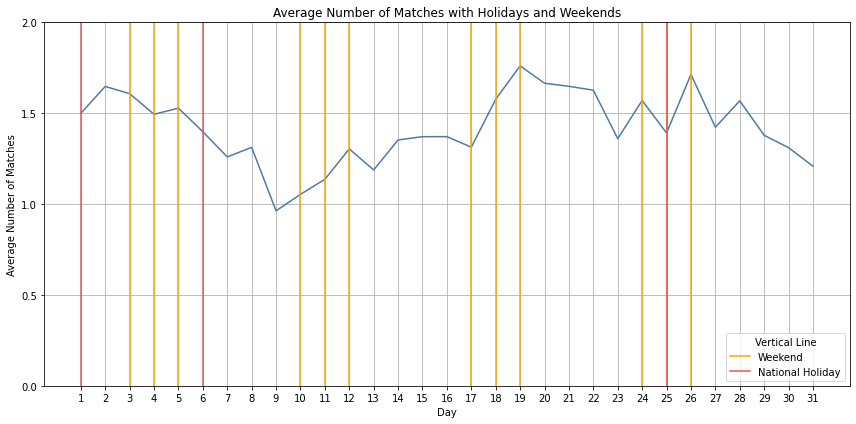

In [18]:
df_total['Day']=df_total.apply(lambda x: x.day2.day, axis=1)

var_agg=['Day', 'matches']
df_agg=df_total[var_agg].groupby(['Day']).mean()
df_agg

plt.figure(figsize=(12, 6))
plt.plot(df_agg['matches'], color='#4E79A7')

plt.xlabel('Day')
plt.ylabel('Average Number of Matches')

plt.xticks(np.arange(1, 32, 1)) 
plt.yticks(np.arange(0, 2.5, 0.5))
plt.grid()

weekend = [3,4,5,10,11,12,17,18,19,24,25,26]
plt.axvline(3, color='orange', label='Weekend')
for p in weekend[1:]:
    plt.axvline(p, color='orange')

holiday = [1,6,25]    
plt.axvline(1, color='#E15759', label='National Holiday')
for p in holiday[1:]:
    plt.axvline(p, color='#E15759')
    
plt.title('Average Number of Matches with Holidays and Weekends')
plt.legend(title='Vertical Line', loc='lower right')
plt.tight_layout()

plt.savefig('Average_Number_of_Matches_holidays.png', format='png')
plt.close

<function matplotlib.pyplot.close(fig=None)>

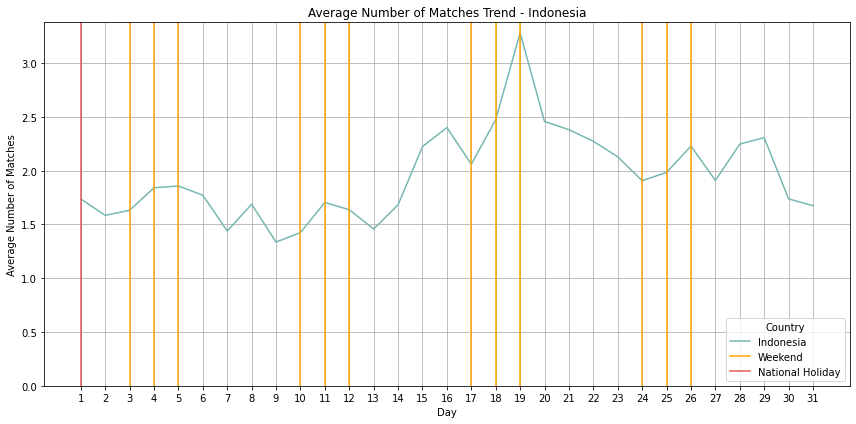

In [19]:
var_agg=['Day', 'country', 'user_id', 'is_active_user', 'matches']
df_agg=df_total[var_agg].groupby(['Day', 'country']).matches.mean()
df_agg=df_agg.unstack(level='country')

plt.figure(figsize=(12, 6))
plt.plot(df_agg['Indonesia'], color='#76B7B2', label='Indonesia')

plt.xlabel('Day')
plt.ylabel('Average Number of Matches')

plt.xticks(np.arange(1, 32, 1)) 
plt.yticks(np.arange(0, 3.5, 0.5))
plt.grid()

xpoints = [3,4,5,10,11,12,17,18,19,24,25,26]
plt.axvline(3, color='orange', label='Weekend')
for p in xpoints[1:]:
    plt.axvline(p, color='orange')

holiday = [1]    
plt.axvline(1, color='#E15759', label='National Holiday')   
    
plt.title('Average Number of Matches Trend - Indonesia')
plt.legend(title='Country', loc='lower right')
plt.tight_layout()

plt.savefig('Average_Number_of_Matches_Indonesia.png', format='png')
plt.close

<function matplotlib.pyplot.close(fig=None)>

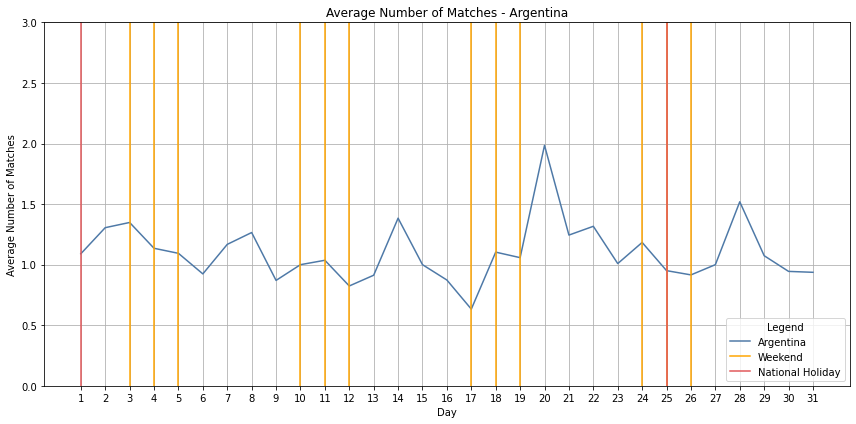

In [20]:
var_agg=['Day', 'country', 'user_id', 'is_active_user', 'matches']
df_agg=df_total[var_agg].groupby(['Day', 'country']).matches.mean()
df_agg=df_agg.unstack(level='country')

plt.figure(figsize=(12, 6))
plt.plot(df_agg['Argentina'], color='#4E79A7', label='Argentina')

plt.xlabel('Day')
plt.ylabel('Average Number of Matches')

plt.xticks(np.arange(1, 32, 1)) 
plt.yticks(np.arange(0, 3.5, 0.5))
plt.grid()

xpoints = [3,4,5,10,11,12,17,18,19,24,25,26]
plt.axvline(3, color='orange', label='Weekend')
for p in xpoints[1:]:
    plt.axvline(p, color='orange')

holiday = [1,25]    
plt.axvline(1, color='#E15759', label='National Holiday')
for p in holiday[1:]:
    plt.axvline(p, color='#E15759')
    
plt.title('Average Number of Matches - Argentina')
plt.legend(title='Legend', loc='lower right')
plt.tight_layout()

plt.savefig('Average_Number_of_Matches_Argentina.png', format='png')
plt.close

<function matplotlib.pyplot.close(fig=None)>

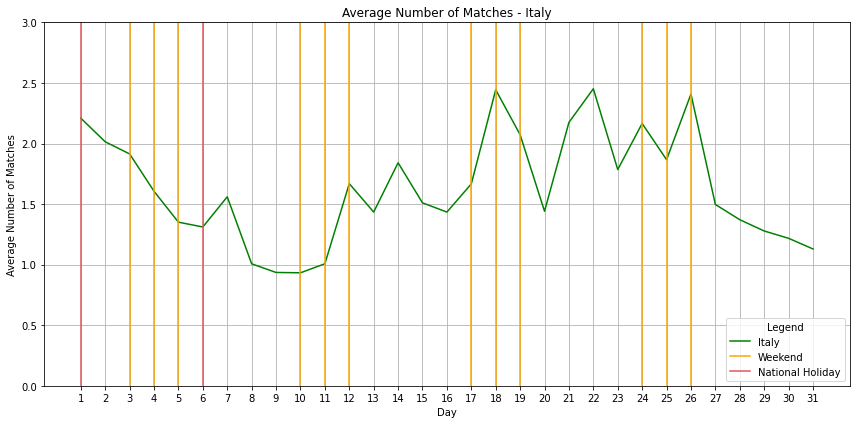

In [21]:
var_agg=['Day', 'country', 'user_id', 'is_active_user', 'matches']
df_agg=df_total[var_agg].groupby(['Day', 'country']).matches.mean()
df_agg=df_agg.unstack(level='country')

plt.figure(figsize=(12, 6))
plt.plot(df_agg['Italy'], color='green', label='Italy')

plt.xlabel('Day')
plt.ylabel('Average Number of Matches')

plt.xticks(np.arange(1, 32, 1)) 
plt.yticks(np.arange(0, 3.5, 0.5))
plt.grid()

xpoints = [3,4,5,10,11,12,17,18,19,24,25,26]
plt.axvline(3, color='orange', label='Weekend')
for p in xpoints[1:]:
    plt.axvline(p, color='orange')

holiday = [1,6]    
plt.axvline(1, color='#E15759', label='National Holiday')
for p in holiday[1:]:
    plt.axvline(p, color='#E15759')
    
plt.title('Average Number of Matches - Italy')
plt.legend(title='Legend', loc='lower right')
plt.tight_layout()

plt.savefig('Average_Number_of_Matches_Italy.png', format='png')
plt.close

<function matplotlib.pyplot.close(fig=None)>

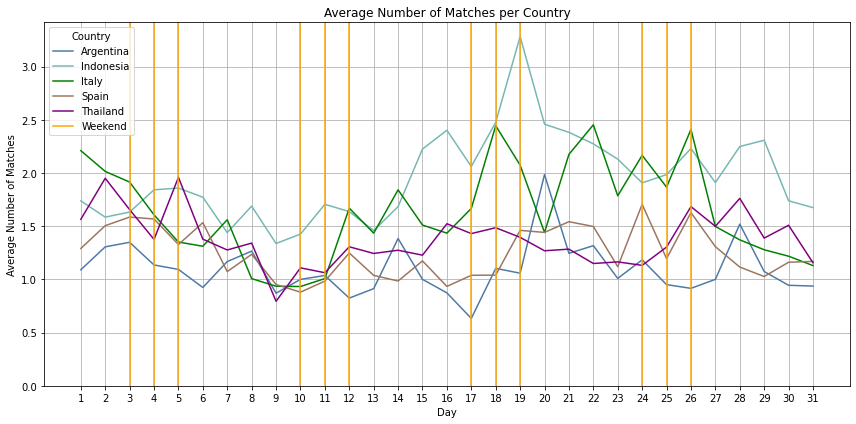

In [22]:
var_agg=['Day', 'country', 'user_id', 'is_active_user', 'matches']
df_agg=df_total[var_agg].groupby(['Day', 'country']).matches.mean()
df_agg=df_agg.unstack(level='country')

plt.figure(figsize=(12, 6))
plt.plot(df_agg['Argentina'], color='#4E79A7', label='Argentina')
plt.plot(df_agg['Indonesia'], color='#76B7B2', label='Indonesia')
plt.plot(df_agg['Italy'], color='green', label='Italy')
plt.plot(df_agg['Spain'], color='#9C755F', label='Spain')
plt.plot(df_agg['Thailand'], color='purple', label='Thailand')

plt.xlabel('Day')
plt.ylabel('Average Number of Matches')

plt.xticks(np.arange(1, 32, 1)) 
plt.yticks(np.arange(0, 3.5, 0.5))
plt.grid()

xpoints = [3,4,5,10,11,12,17,18,19,24,25,26]
plt.axvline(3, color='orange', label='Weekend')
for p in xpoints[1:]:
    plt.axvline(p, color='orange')

plt.title('Average Number of Matches per Country')
plt.legend(title='Country', loc='upper left')
plt.tight_layout()

plt.savefig('Average_Number_of_Matches_all_countries.png', format='png')
plt.close